In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir))

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


In [10]:
def norm_and_plot(matrix_1: torch.Tensor, matrix_2: torch.Tensor, plot=True, cmap="coolwarm"):
    if plot:
        sns.heatmap(torch.abs(matrix_1 - matrix_2).numpy(), cmap=cmap)
        plt.show()
    return torch.norm(matrix_1 - matrix_2, p="fro")

# Analisys on Embeddings weights

In [11]:
emb_weights: Dict[str, torch.Tensor] = {}
for k, v in list_models.items():
    emb_weights[k] = v.model.shared.weight

In [12]:
from transformers import MBartConfig

tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)
random_weight = random_model.model.shared.weight

pre_trained_model: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000")
pre_tr_weight: torch.Tensor = pre_trained_model.model.shared.weight

In [13]:
last_ckcpt_weight = list(emb_weights.values())[-1]
plot = False
with torch.no_grad():
    print(f"norm random - last check. finetuning {norm_and_plot(random_weight, last_ckcpt_weight, plot=plot)}")
    print(f"norm random - pretrained {norm_and_plot(random_weight, pre_tr_weight, plot=plot)}")
    print(f"norm pretrained - last check. finetuning {norm_and_plot(pre_tr_weight, last_ckcpt_weight, plot=plot)}")

norm random - last check. finetuning 461.947509765625
norm random - pretrained 274.3338623046875
norm pretrained - last check. finetuning 305.90960693359375


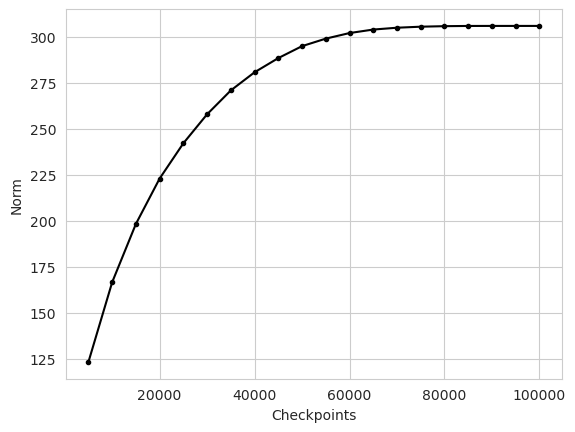

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
    plotting = {int(c.split("-")[-1]): float(torch.norm(w - pre_tr_weight)) for c, w in emb_weights.items()}

plt.plot(plotting.keys(), plotting.values(), ".k-")
plt.xlabel("Checkpoints")
plt.ylabel("Norm")
plt.show()

              0         1         2
0      0.829880  0.008507  0.009735
1      0.846620  0.000000  0.000000
2      0.967740  0.004466  0.004421
3      0.303552  0.052001 -0.099399
4      0.847114 -0.012271  0.000863
...         ...       ...       ...
32025  0.832990 -0.006577 -0.039211
32026  0.842138 -0.009450 -0.031484
32027  0.842220  0.061008  0.042503
32028  0.845463  0.010668  0.007014
32029  0.843980 -0.021013  0.011748

[32030 rows x 3 columns]


<AxesSubplot: >

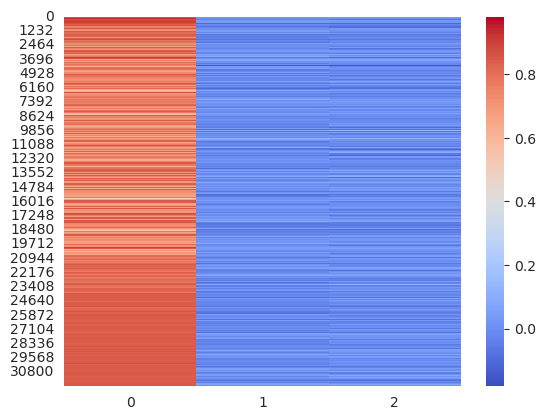

In [46]:
with torch.no_grad():
    df_emb = pd.DataFrame([torch.nn.functional.cosine_similarity(last_ckcpt_weight, pre_tr_weight).numpy(), torch.nn.functional.cosine_similarity(random_weight, pre_tr_weight).numpy(), torch.nn.functional.cosine_similarity(random_weight, last_ckcpt_weight).numpy()])

print(df_emb.T)
sns.heatmap(df_emb.T, cmap="coolwarm")

In [47]:
# Requires long time
# for k, w in tqdm(emb_weights.items()):
#     with torch.no_grad():
#         print(f"{k}, norm {norm_and_plot(w, pre_tr_weight)}")

# Encoder Last Hidden state

In [36]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
tok_out = tokenizer("Hello how are you? This is my dog.", return_tensors="pt")
tokenizer.batch_decode(tok_out['input_ids'].squeeze())

['Hello',
 'how',
 'are',
 'you',
 '?',
 'This',
 'is',
 'my',
 'dog',
 '.',
 '</s>',
 'en_XX']

In [32]:
with torch.no_grad():
    seq2seq_out_pre = pre_trained_model(**tok_out)
    seq2seq_out_rand = random_model(**tok_out)
    last_ft_model = list(list_models.values())[-1]
    seq2seq_out_fine = last_ft_model(**tok_out)

In [33]:
last_hidd_state_pre = seq2seq_out_pre['encoder_last_hidden_state'].squeeze().T
last_hidd_state_rand = seq2seq_out_rand['encoder_last_hidden_state'].squeeze().T
last_hidd_state_fine = seq2seq_out_fine['encoder_last_hidden_state'].squeeze().T

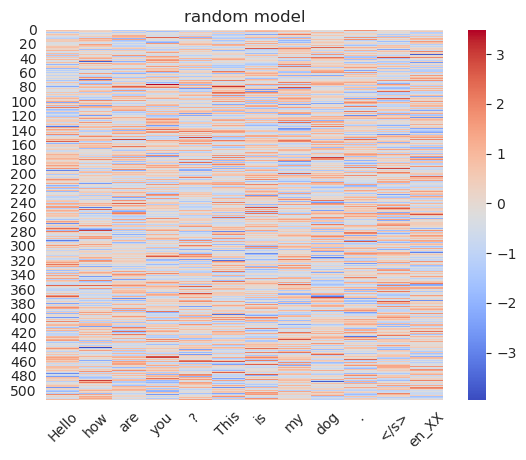

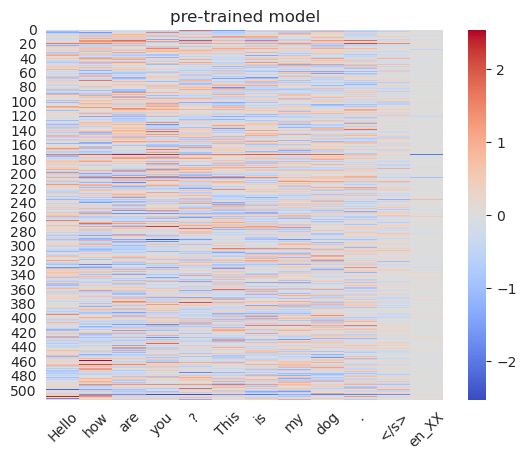

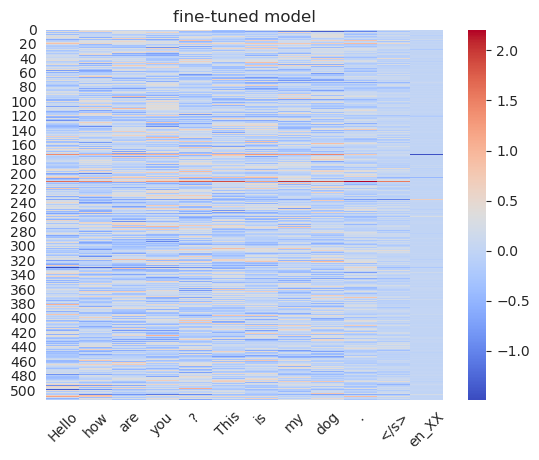

In [37]:
col_names = tokenizer.batch_decode(tok_out['input_ids'].squeeze())
sns.heatmap(pd.DataFrame(last_hidd_state_rand, columns=col_names), cmap="coolwarm").set(title="random model")
plt.xticks(rotation=45)
plt.show()
sns.heatmap(pd.DataFrame(last_hidd_state_pre, columns=col_names), cmap="coolwarm").set(title="pre-trained model")
plt.xticks(rotation=45)
plt.show()
sns.heatmap(pd.DataFrame(last_hidd_state_fine, columns=col_names), cmap="coolwarm").set(title="fine-tuned model")
plt.xticks(rotation=45)
plt.show()

In [25]:
plot = False
with torch.no_grad():
    print(norm_and_plot(last_hidd_state_rand, last_hidd_state_pre, plot))
    print(norm_and_plot(last_hidd_state_pre, last_hidd_state_fine, plot))
    print(norm_and_plot(last_hidd_state_rand, last_hidd_state_fine, plot))

tensor(90.7556)
tensor(36.2622)
tensor(82.4436)


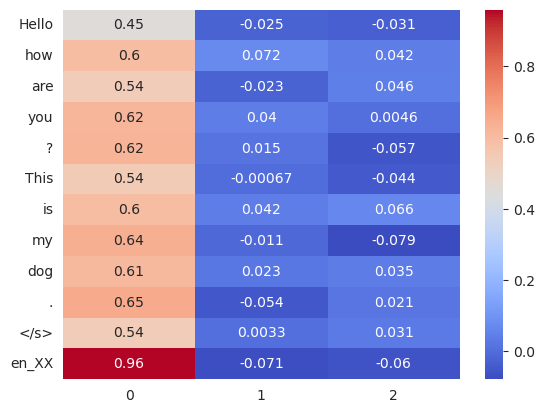

In [49]:
with torch.no_grad():
    cos_sim_pre_fine = torch.nn.functional.cosine_similarity(last_hidd_state_pre, last_hidd_state_fine, dim=0)
    cos_sim_pre_rand = torch.nn.functional.cosine_similarity(last_hidd_state_pre, last_hidd_state_rand, dim=0)
    cos_sim_rand_fine = torch.nn.functional.cosine_similarity(last_hidd_state_rand, last_hidd_state_fine, dim=0)
    df_cos_hs = pd.DataFrame([cos_sim_pre_fine.numpy(), cos_sim_pre_rand.numpy(), cos_sim_rand_fine.numpy()], columns=col_names)

#print(df_cos)
sns.heatmap(df_cos_hs.T, cmap="coolwarm", annot=True)
plt.show()

# Logits analysis

In [43]:
logits_ft = seq2seq_out_fine['logits'].squeeze()
logits_pre = seq2seq_out_pre['logits'].squeeze()
logits_rand = seq2seq_out_rand['logits'].squeeze()

In [44]:
with torch.no_grad():
    print(torch.norm(logits_pre - logits_ft))
    print(torch.norm(logits_pre - logits_rand))

tensor(1165.5029)
tensor(3964.9065)


<AxesSubplot: >

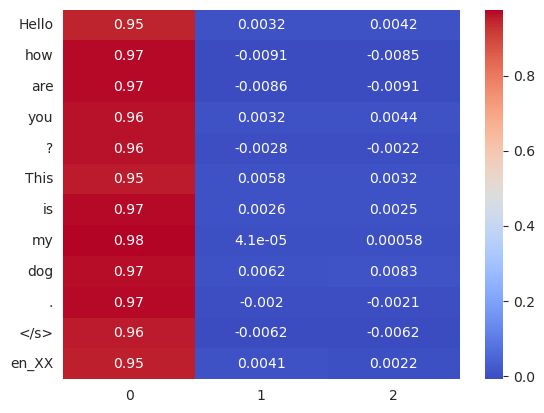

In [48]:
cos_sim_logits_ft_pre = torch.nn.functional.cosine_similarity(logits_ft, logits_pre, dim=1)
cos_sim_logits_rnd_pre = torch.nn.functional.cosine_similarity(logits_rand, logits_pre, dim=1)
cos_sim_logits_rnd_ft = torch.nn.functional.cosine_similarity(logits_rand, logits_ft, dim=1)

df_cos_logits = pd.DataFrame(
    [cos_sim_logits_ft_pre.numpy(), cos_sim_logits_rnd_pre.numpy(), cos_sim_logits_rnd_ft.numpy()], columns=col_names)
#print(df_cos_logits)
sns.heatmap(df_cos_logits.T, cmap="coolwarm", annot=True)

In [65]:
print(last_ft_model)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(32030, 512, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(32030, 512, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 512)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=